In [1]:
import os
import torch
import random
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from datasets import DatasetDict, Dataset
from transformers import AutoImageProcessor
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# Step 2: Load and Prepare the Dataset

Since you have a folder structure where each folder represents a class, we will use datasets from Hugging Face to load the dataset efficiently.

2.1 - Load Data and Split into Train/Validation Sets

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the paths to your training and testing datasets
train_data_dir = "C:/Users/Amir/Desktop/skin cancer paper/skin cancer isic/Skin Cancer ISIC/Skin cancer ISIC The International Skin Imaging Collaboration/train"  # Replace with the path to your training dataset
test_data_dir = "C:/Users/Amir/Desktop/skin cancer paper/skin cancer isic/Skin Cancer ISIC/Skin cancer ISIC The International Skin Imaging Collaboration/test"  # Replace with the path to your testing dataset

# Define transformations for the images
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),  # Resize images to 224x224 (required for ConvNext)
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load the training dataset
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)

# Load the testing dataset
test_dataset = datasets.ImageFolder(test_data_dir, transform=transform)

# Split the training set into train and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Check the number of classes
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the sizes of the datasets
print(f"Training subset size: {len(train_subset)}")
print(f"Validation subset size: {len(val_subset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Number of classes: 9
Training subset size: 1791
Validation subset size: 448
Testing dataset size: 118


In [3]:
num_classes

9

# Using class weights for class imbalance

In [4]:
import numpy as np

# Get the class labels from the training dataset
class_labels = [label for _, label in train_dataset]

# Compute class counts
class_counts = np.bincount(class_labels)

# Compute class weights
class_weights = 1. / class_counts

# Normalize the weights (optional but recommended)
class_weights = class_weights / class_weights.sum()

# Print class weights
print("Class counts:", class_counts)
print("Class weights:", class_weights)

Class counts: [114 376  95 438 357 462  77 181 139]
Class weights: [0.15974328 0.0484328  0.19169194 0.04157702 0.05101046 0.03941717
 0.23650304 0.10061179 0.13101248]


# Importing model from huggingface

Add Batch Normalization and Dropout to the Classifier Head

In [6]:
from transformers import ConvNextForImageClassification
import torch.nn as nn

# Load the pre-trained ConvNext model
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224", num_labels=num_classes,   ignore_mismatched_sizes=True
)


# Add Batch Normalization and Dropout to the classifier head
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout with 50% probability
    nn.Linear(model.classifier.in_features, 512),  # Add an intermediate layer
    nn.BatchNorm1d(512),  # Add Batch Normalization
    nn.ReLU(),  # Add activation function
    nn.Linear(512, num_classes)  # Final output layer
)



# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

# Freeze Early Layers and Train Only the Classifier Head

In [ ]:
'''
# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier head
for param in model.classifier.parameters():
    param.requires_grad = True '''

# Training 

In [28]:
import torch
import torch.optim as optim
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


'''
# Convert class weights to a tensor and move to the device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)'
'''
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# CSV file to store the metrics
csv_filename = "training_metrics.csv"
df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
df.to_csv(csv_filename, index=False)  # Create an empty file with headers

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap train_loader with tqdm for a progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar description with current loss and accuracy
        train_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    # Wrap val_loader with tqdm for a progress bar
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits  # Adjust if your model doesn't output .logits
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update the progress bar description with current loss and accuracy
            val_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Save the metrics to a CSV file
    epoch_data = {
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_accuracy,
        "Val Loss": val_loss,
        "Val Accuracy": val_accuracy
    }
    
    df = pd.DataFrame([epoch_data])  # Convert dictionary to DataFrame
    df.to_csv(csv_filename, mode='a', header=False, index=False)  # Append to CSV


Epoch [1/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.78it/s, accuracy=87.1, loss=0.246] 


Epoch [1/100], Train Loss: 0.2929, Train Accuracy: 87.10%


Epoch [1/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.51it/s, accuracy=68.8, loss=0.487]


Epoch [1/100], Val Loss: 1.0786, Val Accuracy: 68.75%


Epoch [2/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=87.4, loss=0.553] 


Epoch [2/100], Train Loss: 0.2961, Train Accuracy: 87.38%


Epoch [2/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=65, loss=1.06]   


Epoch [2/100], Val Loss: 1.1052, Val Accuracy: 64.96%


Epoch [3/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=87.4, loss=0.335] 


Epoch [3/100], Train Loss: 0.2823, Train Accuracy: 87.38%


Epoch [3/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s, accuracy=73.4, loss=0.507]


Epoch [3/100], Val Loss: 1.0707, Val Accuracy: 73.44%


Epoch [4/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.84it/s, accuracy=88.6, loss=0.169]


Epoch [4/100], Train Loss: 0.2810, Train Accuracy: 88.55%


Epoch [4/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s, accuracy=72.5, loss=0.852]


Epoch [4/100], Val Loss: 1.1328, Val Accuracy: 72.54%


Epoch [5/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=86.4, loss=0.397]


Epoch [5/100], Train Loss: 0.3053, Train Accuracy: 86.43%


Epoch [5/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.80it/s, accuracy=67.4, loss=0.597]


Epoch [5/100], Val Loss: 1.0756, Val Accuracy: 67.41%


Epoch [6/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.89it/s, accuracy=87.7, loss=0.297]


Epoch [6/100], Train Loss: 0.2822, Train Accuracy: 87.66%


Epoch [6/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=66.7, loss=1]    


Epoch [6/100], Val Loss: 1.0425, Val Accuracy: 66.74%


Epoch [7/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=89.1, loss=0.232]


Epoch [7/100], Train Loss: 0.2815, Train Accuracy: 89.06%


Epoch [7/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=65.6, loss=1.18] 


Epoch [7/100], Val Loss: 1.2005, Val Accuracy: 65.62%


Epoch [8/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.88it/s, accuracy=88.2, loss=0.463]


Epoch [8/100], Train Loss: 0.2824, Train Accuracy: 88.16%


Epoch [8/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=70.8, loss=0.534]


Epoch [8/100], Val Loss: 1.0754, Val Accuracy: 70.76%


Epoch [9/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=87.8, loss=0.35] 


Epoch [9/100], Train Loss: 0.2781, Train Accuracy: 87.83%


Epoch [9/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s, accuracy=69.6, loss=1.13]


Epoch [9/100], Val Loss: 1.1265, Val Accuracy: 69.64%


Epoch [10/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=88.6, loss=0.212] 


Epoch [10/100], Train Loss: 0.2743, Train Accuracy: 88.61%


Epoch [10/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s, accuracy=67.4, loss=0.718]


Epoch [10/100], Val Loss: 1.1525, Val Accuracy: 67.41%


Epoch [11/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=86.6, loss=0.15] 


Epoch [11/100], Train Loss: 0.3145, Train Accuracy: 86.60%


Epoch [11/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=71, loss=0.825]  


Epoch [11/100], Val Loss: 1.0189, Val Accuracy: 70.98%


Epoch [12/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=88.5, loss=0.241] 


Epoch [12/100], Train Loss: 0.2578, Train Accuracy: 88.50%


Epoch [12/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.45it/s, accuracy=69.4, loss=0.915]


Epoch [12/100], Val Loss: 1.0698, Val Accuracy: 69.42%


Epoch [13/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.75it/s, accuracy=88.6, loss=0.302] 


Epoch [13/100], Train Loss: 0.2598, Train Accuracy: 88.61%


Epoch [13/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.63it/s, accuracy=71.4, loss=0.79] 


Epoch [13/100], Val Loss: 1.0181, Val Accuracy: 71.43%


Epoch [14/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.78it/s, accuracy=88.2, loss=0.241] 


Epoch [14/100], Train Loss: 0.2783, Train Accuracy: 88.22%


Epoch [14/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s, accuracy=68.8, loss=1.08] 


Epoch [14/100], Val Loss: 0.9748, Val Accuracy: 68.75%


Epoch [15/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=87.5, loss=0.282] 


Epoch [15/100], Train Loss: 0.2896, Train Accuracy: 87.55%


Epoch [15/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s, accuracy=69.9, loss=0.47] 


Epoch [15/100], Val Loss: 1.0352, Val Accuracy: 69.87%


Epoch [16/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=88.3, loss=0.318]


Epoch [16/100], Train Loss: 0.2746, Train Accuracy: 88.27%


Epoch [16/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s, accuracy=66.3, loss=1.19]


Epoch [16/100], Val Loss: 1.4151, Val Accuracy: 66.29%


Epoch [17/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.87it/s, accuracy=88.6, loss=0.166] 


Epoch [17/100], Train Loss: 0.2626, Train Accuracy: 88.55%


Epoch [17/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.80it/s, accuracy=69.2, loss=1.16] 


Epoch [17/100], Val Loss: 1.1691, Val Accuracy: 69.20%


Epoch [18/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=87.9, loss=0.0938]


Epoch [18/100], Train Loss: 0.2720, Train Accuracy: 87.88%


Epoch [18/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=71.2, loss=1.04] 


Epoch [18/100], Val Loss: 1.0874, Val Accuracy: 71.21%


Epoch [19/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=89.6, loss=0.273]


Epoch [19/100], Train Loss: 0.2691, Train Accuracy: 89.56%


Epoch [19/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.80it/s, accuracy=71.4, loss=0.885]


Epoch [19/100], Val Loss: 1.2004, Val Accuracy: 71.43%


Epoch [20/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=89.3, loss=0.127] 


Epoch [20/100], Train Loss: 0.2365, Train Accuracy: 89.28%


Epoch [20/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s, accuracy=70.3, loss=0.619]


Epoch [20/100], Val Loss: 1.0035, Val Accuracy: 70.31%


Epoch [21/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=89.6, loss=0.0798]


Epoch [21/100], Train Loss: 0.2180, Train Accuracy: 89.56%


Epoch [21/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s, accuracy=75.2, loss=0.619]


Epoch [21/100], Val Loss: 0.8419, Val Accuracy: 75.22%


Epoch [22/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=91.1, loss=0.303] 


Epoch [22/100], Train Loss: 0.1910, Train Accuracy: 91.12%


Epoch [22/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.80it/s, accuracy=71.9, loss=0.626]


Epoch [22/100], Val Loss: 0.9575, Val Accuracy: 71.88%


Epoch [23/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=91.6, loss=0.0694]


Epoch [23/100], Train Loss: 0.1880, Train Accuracy: 91.57%


Epoch [23/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s, accuracy=76.1, loss=0.583]


Epoch [23/100], Val Loss: 0.8531, Val Accuracy: 76.12%


Epoch [24/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=90.7, loss=0.239] 


Epoch [24/100], Train Loss: 0.1932, Train Accuracy: 90.73%


Epoch [24/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.67it/s, accuracy=75, loss=0.514]  


Epoch [24/100], Val Loss: 0.9538, Val Accuracy: 75.00%


Epoch [25/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=91.5, loss=0.0525]


Epoch [25/100], Train Loss: 0.1743, Train Accuracy: 91.51%


Epoch [25/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s, accuracy=73, loss=0.579]  


Epoch [25/100], Val Loss: 1.0173, Val Accuracy: 72.99%


Epoch [26/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.84it/s, accuracy=91.6, loss=0.239] 


Epoch [26/100], Train Loss: 0.1765, Train Accuracy: 91.57%


Epoch [26/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s, accuracy=74.6, loss=0.302]


Epoch [26/100], Val Loss: 0.9717, Val Accuracy: 74.55%


Epoch [27/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=92.7, loss=0.16]  


Epoch [27/100], Train Loss: 0.1606, Train Accuracy: 92.74%


Epoch [27/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s, accuracy=74.8, loss=0.309]


Epoch [27/100], Val Loss: 0.9682, Val Accuracy: 74.78%


Epoch [28/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.87it/s, accuracy=91, loss=0.37]    


Epoch [28/100], Train Loss: 0.1892, Train Accuracy: 91.01%


Epoch [28/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s, accuracy=75.2, loss=0.664]


Epoch [28/100], Val Loss: 0.9388, Val Accuracy: 75.22%


Epoch [29/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=91.3, loss=0.15]  


Epoch [29/100], Train Loss: 0.1625, Train Accuracy: 91.29%


Epoch [29/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.85it/s, accuracy=75.2, loss=0.624]


Epoch [29/100], Val Loss: 1.0114, Val Accuracy: 75.22%


Epoch [30/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=92.9, loss=0.197] 


Epoch [30/100], Train Loss: 0.1547, Train Accuracy: 92.91%


Epoch [30/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s, accuracy=73.7, loss=0.571]


Epoch [30/100], Val Loss: 0.9655, Val Accuracy: 73.66%


Epoch [31/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.88it/s, accuracy=91, loss=0.19]    


Epoch [31/100], Train Loss: 0.1698, Train Accuracy: 90.95%


Epoch [31/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=73.9, loss=0.577]


Epoch [31/100], Val Loss: 1.0230, Val Accuracy: 73.88%


Epoch [32/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=91.7, loss=0.278] 


Epoch [32/100], Train Loss: 0.1809, Train Accuracy: 91.68%


Epoch [32/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s, accuracy=75, loss=0.61]   


Epoch [32/100], Val Loss: 0.9881, Val Accuracy: 75.00%


Epoch [33/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=91.9, loss=0.102] 


Epoch [33/100], Train Loss: 0.1741, Train Accuracy: 91.90%


Epoch [33/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s, accuracy=74.1, loss=0.529]


Epoch [33/100], Val Loss: 0.9463, Val Accuracy: 74.11%


Epoch [34/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=92, loss=0.0733]  


Epoch [34/100], Train Loss: 0.1757, Train Accuracy: 91.96%


Epoch [34/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.80it/s, accuracy=73.4, loss=0.585]


Epoch [34/100], Val Loss: 0.9470, Val Accuracy: 73.44%


Epoch [35/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=92.1, loss=0.232] 


Epoch [35/100], Train Loss: 0.1791, Train Accuracy: 92.13%


Epoch [35/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=75, loss=0.496]  


Epoch [35/100], Val Loss: 0.9784, Val Accuracy: 75.00%


Epoch [36/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=92.1, loss=0.134] 


Epoch [36/100], Train Loss: 0.1567, Train Accuracy: 92.13%


Epoch [36/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s, accuracy=72.3, loss=0.509]


Epoch [36/100], Val Loss: 0.9682, Val Accuracy: 72.32%


Epoch [37/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=92.7, loss=0.153] 


Epoch [37/100], Train Loss: 0.1615, Train Accuracy: 92.69%


Epoch [37/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.76it/s, accuracy=73.2, loss=0.531]


Epoch [37/100], Val Loss: 1.0117, Val Accuracy: 73.21%


Epoch [38/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=91.4, loss=0.147] 


Epoch [38/100], Train Loss: 0.1677, Train Accuracy: 91.40%


Epoch [38/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.67it/s, accuracy=73.2, loss=0.395]


Epoch [38/100], Val Loss: 1.0132, Val Accuracy: 73.21%


Epoch [39/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.79it/s, accuracy=93, loss=0.16]    


Epoch [39/100], Train Loss: 0.1584, Train Accuracy: 92.96%


Epoch [39/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.45it/s, accuracy=75.9, loss=0.569]


Epoch [39/100], Val Loss: 0.9048, Val Accuracy: 75.89%


Epoch [40/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.78it/s, accuracy=91.5, loss=0.0764]


Epoch [40/100], Train Loss: 0.1680, Train Accuracy: 91.46%


Epoch [40/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s, accuracy=72.8, loss=0.278]


Epoch [40/100], Val Loss: 0.9583, Val Accuracy: 72.77%


Epoch [41/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.78it/s, accuracy=91.8, loss=0.11]  


Epoch [41/100], Train Loss: 0.1798, Train Accuracy: 91.85%


Epoch [41/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.53it/s, accuracy=73.9, loss=0.672]


Epoch [41/100], Val Loss: 0.9592, Val Accuracy: 73.88%


Epoch [42/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=92.5, loss=0.0931]


Epoch [42/100], Train Loss: 0.1591, Train Accuracy: 92.52%


Epoch [42/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s, accuracy=73.4, loss=0.471]


Epoch [42/100], Val Loss: 0.9198, Val Accuracy: 73.44%


Epoch [43/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=92, loss=0.233]   


Epoch [43/100], Train Loss: 0.1659, Train Accuracy: 92.02%


Epoch [43/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s, accuracy=75, loss=0.511]  


Epoch [43/100], Val Loss: 0.9490, Val Accuracy: 75.00%


Epoch [44/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=92, loss=0.195]   


Epoch [44/100], Train Loss: 0.1764, Train Accuracy: 91.96%


Epoch [44/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.76it/s, accuracy=73.2, loss=0.429]


Epoch [44/100], Val Loss: 0.9736, Val Accuracy: 73.21%


Epoch [45/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=91.3, loss=0.13]  


Epoch [45/100], Train Loss: 0.1783, Train Accuracy: 91.35%


Epoch [45/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s, accuracy=73.2, loss=0.786]


Epoch [45/100], Val Loss: 0.9422, Val Accuracy: 73.21%


Epoch [46/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=92.1, loss=0.141] 


Epoch [46/100], Train Loss: 0.1621, Train Accuracy: 92.07%


Epoch [46/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.55it/s, accuracy=74.1, loss=0.351]


Epoch [46/100], Val Loss: 0.9722, Val Accuracy: 74.11%


Epoch [47/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.81it/s, accuracy=92.6, loss=0.303] 


Epoch [47/100], Train Loss: 0.1564, Train Accuracy: 92.57%


Epoch [47/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s, accuracy=74.1, loss=0.302]


Epoch [47/100], Val Loss: 0.9150, Val Accuracy: 74.11%


Epoch [48/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=92.6, loss=0.172] 


Epoch [48/100], Train Loss: 0.1585, Train Accuracy: 92.57%


Epoch [48/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=73.9, loss=0.73] 


Epoch [48/100], Val Loss: 1.0486, Val Accuracy: 73.88%


Epoch [49/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.81it/s, accuracy=92.6, loss=0.118] 


Epoch [49/100], Train Loss: 0.1583, Train Accuracy: 92.57%


Epoch [49/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s, accuracy=75.4, loss=0.405]


Epoch [49/100], Val Loss: 0.8249, Val Accuracy: 75.45%


Epoch [50/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=91.8, loss=0.162] 


Epoch [50/100], Train Loss: 0.1911, Train Accuracy: 91.79%


Epoch [50/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s, accuracy=73, loss=0.383]  


Epoch [50/100], Val Loss: 1.0345, Val Accuracy: 72.99%


Epoch [51/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=91.3, loss=0.165] 


Epoch [51/100], Train Loss: 0.1701, Train Accuracy: 91.29%


Epoch [51/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.54it/s, accuracy=70.5, loss=0.853]


Epoch [51/100], Val Loss: 1.0286, Val Accuracy: 70.54%


Epoch [52/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.79it/s, accuracy=91.7, loss=0.168] 


Epoch [52/100], Train Loss: 0.1651, Train Accuracy: 91.68%


Epoch [52/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=71, loss=0.704]  


Epoch [52/100], Val Loss: 1.0256, Val Accuracy: 70.98%


Epoch [53/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=91.8, loss=0.135] 


Epoch [53/100], Train Loss: 0.1625, Train Accuracy: 91.85%


Epoch [53/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s, accuracy=76.3, loss=0.594]


Epoch [53/100], Val Loss: 0.8897, Val Accuracy: 76.34%


Epoch [54/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=92.5, loss=0.166]  


Epoch [54/100], Train Loss: 0.1627, Train Accuracy: 92.46%


Epoch [54/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s, accuracy=74.6, loss=0.535]


Epoch [54/100], Val Loss: 0.9281, Val Accuracy: 74.55%


Epoch [55/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=92.8, loss=0.109] 


Epoch [55/100], Train Loss: 0.1490, Train Accuracy: 92.80%


Epoch [55/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.85it/s, accuracy=75, loss=0.339]  


Epoch [55/100], Val Loss: 0.9290, Val Accuracy: 75.00%


Epoch [56/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.87it/s, accuracy=92.5, loss=0.109] 


Epoch [56/100], Train Loss: 0.1731, Train Accuracy: 92.46%


Epoch [56/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s, accuracy=72.1, loss=0.582]


Epoch [56/100], Val Loss: 0.9832, Val Accuracy: 72.10%


Epoch [57/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.89it/s, accuracy=91.5, loss=0.0406]


Epoch [57/100], Train Loss: 0.1649, Train Accuracy: 91.46%


Epoch [57/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s, accuracy=73.2, loss=0.639]


Epoch [57/100], Val Loss: 0.9747, Val Accuracy: 73.21%


Epoch [58/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=91.8, loss=0.111] 


Epoch [58/100], Train Loss: 0.1589, Train Accuracy: 91.79%


Epoch [58/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s, accuracy=74.6, loss=0.417]


Epoch [58/100], Val Loss: 0.9621, Val Accuracy: 74.55%


Epoch [59/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.88it/s, accuracy=91.6, loss=0.205] 


Epoch [59/100], Train Loss: 0.1639, Train Accuracy: 91.57%


Epoch [59/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=74.3, loss=0.564]


Epoch [59/100], Val Loss: 0.9595, Val Accuracy: 74.33%


Epoch [60/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=91.2, loss=0.266] 


Epoch [60/100], Train Loss: 0.1728, Train Accuracy: 91.18%


Epoch [60/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=74.6, loss=0.624]


Epoch [60/100], Val Loss: 0.9495, Val Accuracy: 74.55%


Epoch [61/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=91.7, loss=0.124] 


Epoch [61/100], Train Loss: 0.1758, Train Accuracy: 91.68%


Epoch [61/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s, accuracy=72.8, loss=0.574]


Epoch [61/100], Val Loss: 0.9766, Val Accuracy: 72.77%


Epoch [62/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.79it/s, accuracy=93.1, loss=0.173] 


Epoch [62/100], Train Loss: 0.1643, Train Accuracy: 93.08%


Epoch [62/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.58it/s, accuracy=73.4, loss=0.506]


Epoch [62/100], Val Loss: 0.9740, Val Accuracy: 73.44%


Epoch [63/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=91.3, loss=0.276] 


Epoch [63/100], Train Loss: 0.1824, Train Accuracy: 91.29%


Epoch [63/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s, accuracy=72.5, loss=0.792]


Epoch [63/100], Val Loss: 1.0717, Val Accuracy: 72.54%


Epoch [64/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=91.1, loss=0.175] 


Epoch [64/100], Train Loss: 0.1870, Train Accuracy: 91.07%


Epoch [64/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s, accuracy=72.5, loss=0.433]


Epoch [64/100], Val Loss: 1.0631, Val Accuracy: 72.54%


Epoch [65/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=92, loss=0.124]   


Epoch [65/100], Train Loss: 0.1682, Train Accuracy: 92.02%


Epoch [65/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s, accuracy=75.2, loss=0.563]


Epoch [65/100], Val Loss: 0.9914, Val Accuracy: 75.22%


Epoch [66/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=92.2, loss=0.117] 


Epoch [66/100], Train Loss: 0.1571, Train Accuracy: 92.18%


Epoch [66/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=76.6, loss=0.65] 


Epoch [66/100], Val Loss: 0.9520, Val Accuracy: 76.56%


Epoch [67/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=92.2, loss=0.167] 


Epoch [67/100], Train Loss: 0.1777, Train Accuracy: 92.18%


Epoch [67/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.85it/s, accuracy=73.4, loss=0.807]


Epoch [67/100], Val Loss: 0.9740, Val Accuracy: 73.44%


Epoch [68/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=92.4, loss=0.127] 


Epoch [68/100], Train Loss: 0.1689, Train Accuracy: 92.35%


Epoch [68/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s, accuracy=74.8, loss=0.418]


Epoch [68/100], Val Loss: 0.8933, Val Accuracy: 74.78%


Epoch [69/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=92, loss=0.138]   


Epoch [69/100], Train Loss: 0.1677, Train Accuracy: 91.96%


Epoch [69/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s, accuracy=71.4, loss=0.618]


Epoch [69/100], Val Loss: 1.0136, Val Accuracy: 71.43%


Epoch [70/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.76it/s, accuracy=92.6, loss=0.105] 


Epoch [70/100], Train Loss: 0.1679, Train Accuracy: 92.57%


Epoch [70/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s, accuracy=73.7, loss=0.628]


Epoch [70/100], Val Loss: 0.9679, Val Accuracy: 73.66%


Epoch [71/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=92, loss=0.263]   


Epoch [71/100], Train Loss: 0.1745, Train Accuracy: 92.02%


Epoch [71/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s, accuracy=71.9, loss=0.391]


Epoch [71/100], Val Loss: 1.1174, Val Accuracy: 71.88%


Epoch [72/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.79it/s, accuracy=92, loss=0.218]   


Epoch [72/100], Train Loss: 0.1738, Train Accuracy: 91.96%


Epoch [72/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s, accuracy=75.2, loss=0.559]


Epoch [72/100], Val Loss: 0.9260, Val Accuracy: 75.22%


Epoch [73/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=92.5, loss=0.191] 


Epoch [73/100], Train Loss: 0.1523, Train Accuracy: 92.52%


Epoch [73/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s, accuracy=74.1, loss=0.372]


Epoch [73/100], Val Loss: 0.9820, Val Accuracy: 74.11%


Epoch [74/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.79it/s, accuracy=92.3, loss=0.0534]


Epoch [74/100], Train Loss: 0.1610, Train Accuracy: 92.29%


Epoch [74/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.67it/s, accuracy=74.1, loss=0.559]


Epoch [74/100], Val Loss: 0.9525, Val Accuracy: 74.11%


Epoch [75/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=92.2, loss=0.0771]


Epoch [75/100], Train Loss: 0.1692, Train Accuracy: 92.18%


Epoch [75/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s, accuracy=73.2, loss=0.669]


Epoch [75/100], Val Loss: 1.0127, Val Accuracy: 73.21%


Epoch [76/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.79it/s, accuracy=91.8, loss=0.145] 


Epoch [76/100], Train Loss: 0.1763, Train Accuracy: 91.79%


Epoch [76/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s, accuracy=71.2, loss=0.763]


Epoch [76/100], Val Loss: 1.0692, Val Accuracy: 71.21%


Epoch [77/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.78it/s, accuracy=93.2, loss=0.0924]


Epoch [77/100], Train Loss: 0.1538, Train Accuracy: 93.19%


Epoch [77/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s, accuracy=74.1, loss=0.782]


Epoch [77/100], Val Loss: 0.9494, Val Accuracy: 74.11%


Epoch [78/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.79it/s, accuracy=92.1, loss=0.22]  


Epoch [78/100], Train Loss: 0.1655, Train Accuracy: 92.07%


Epoch [78/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s, accuracy=73.7, loss=0.602]


Epoch [78/100], Val Loss: 1.0106, Val Accuracy: 73.66%


Epoch [79/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=91.6, loss=0.108] 


Epoch [79/100], Train Loss: 0.1613, Train Accuracy: 91.57%


Epoch [79/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s, accuracy=71.9, loss=0.586]


Epoch [79/100], Val Loss: 1.0712, Val Accuracy: 71.88%


Epoch [80/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=93.1, loss=0.127] 


Epoch [80/100], Train Loss: 0.1580, Train Accuracy: 93.13%


Epoch [80/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.67it/s, accuracy=73.9, loss=0.353]


Epoch [80/100], Val Loss: 0.9543, Val Accuracy: 73.88%


Epoch [81/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.79it/s, accuracy=91.5, loss=0.0702]


Epoch [81/100], Train Loss: 0.1687, Train Accuracy: 91.46%


Epoch [81/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s, accuracy=74.8, loss=0.432]


Epoch [81/100], Val Loss: 0.9149, Val Accuracy: 74.78%


Epoch [82/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.79it/s, accuracy=92.4, loss=0.126] 


Epoch [82/100], Train Loss: 0.1575, Train Accuracy: 92.35%


Epoch [82/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.63it/s, accuracy=74.6, loss=0.48] 


Epoch [82/100], Val Loss: 0.8963, Val Accuracy: 74.55%


Epoch [83/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=91.2, loss=0.321] 


Epoch [83/100], Train Loss: 0.1747, Train Accuracy: 91.23%


Epoch [83/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s, accuracy=72.3, loss=0.809]


Epoch [83/100], Val Loss: 1.0863, Val Accuracy: 72.32%


Epoch [84/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=91.5, loss=0.277] 


Epoch [84/100], Train Loss: 0.1743, Train Accuracy: 91.51%


Epoch [84/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=73, loss=0.645]  


Epoch [84/100], Val Loss: 0.9396, Val Accuracy: 72.99%


Epoch [85/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=92.7, loss=0.152] 


Epoch [85/100], Train Loss: 0.1531, Train Accuracy: 92.69%


Epoch [85/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=73.4, loss=0.666]


Epoch [85/100], Val Loss: 0.9949, Val Accuracy: 73.44%


Epoch [86/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.79it/s, accuracy=92.6, loss=0.242] 


Epoch [86/100], Train Loss: 0.1593, Train Accuracy: 92.63%


Epoch [86/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s, accuracy=73, loss=0.585]  


Epoch [86/100], Val Loss: 0.9997, Val Accuracy: 72.99%


Epoch [87/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.79it/s, accuracy=92, loss=0.13]    


Epoch [87/100], Train Loss: 0.1613, Train Accuracy: 91.96%


Epoch [87/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s, accuracy=73.4, loss=0.537]


Epoch [87/100], Val Loss: 0.9354, Val Accuracy: 73.44%


Epoch [88/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=90.7, loss=0.198] 


Epoch [88/100], Train Loss: 0.1797, Train Accuracy: 90.68%


Epoch [88/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s, accuracy=75.7, loss=0.634]


Epoch [88/100], Val Loss: 0.9536, Val Accuracy: 75.67%


Epoch [89/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=91.5, loss=0.109] 


Epoch [89/100], Train Loss: 0.1893, Train Accuracy: 91.46%


Epoch [89/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=72.3, loss=0.51] 


Epoch [89/100], Val Loss: 0.9657, Val Accuracy: 72.32%


Epoch [90/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=92.3, loss=0.296] 


Epoch [90/100], Train Loss: 0.1625, Train Accuracy: 92.29%


Epoch [90/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=73.7, loss=0.521]


Epoch [90/100], Val Loss: 0.9783, Val Accuracy: 73.66%


Epoch [91/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=93, loss=0.0958]  


Epoch [91/100], Train Loss: 0.1459, Train Accuracy: 92.96%


Epoch [91/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.80it/s, accuracy=73.4, loss=0.425]


Epoch [91/100], Val Loss: 0.9323, Val Accuracy: 73.44%


Epoch [92/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=91, loss=0.176]   


Epoch [92/100], Train Loss: 0.1705, Train Accuracy: 90.95%


Epoch [92/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s, accuracy=73.2, loss=0.527]


Epoch [92/100], Val Loss: 1.0226, Val Accuracy: 73.21%


Epoch [93/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=92.5, loss=0.109] 


Epoch [93/100], Train Loss: 0.1617, Train Accuracy: 92.46%


Epoch [93/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.80it/s, accuracy=75.4, loss=0.659]


Epoch [93/100], Val Loss: 0.9390, Val Accuracy: 75.45%


Epoch [94/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=92.4, loss=0.162] 


Epoch [94/100], Train Loss: 0.1628, Train Accuracy: 92.35%


Epoch [94/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s, accuracy=73, loss=0.526]  


Epoch [94/100], Val Loss: 1.0090, Val Accuracy: 72.99%


Epoch [95/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=92.5, loss=0.153] 


Epoch [95/100], Train Loss: 0.1491, Train Accuracy: 92.52%


Epoch [95/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s, accuracy=73.9, loss=0.614]


Epoch [95/100], Val Loss: 0.9362, Val Accuracy: 73.88%


Epoch [96/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=92.7, loss=0.243] 


Epoch [96/100], Train Loss: 0.1533, Train Accuracy: 92.69%


Epoch [96/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.80it/s, accuracy=74.8, loss=0.603]


Epoch [96/100], Val Loss: 0.9480, Val Accuracy: 74.78%


Epoch [97/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=91.7, loss=0.151] 


Epoch [97/100], Train Loss: 0.1894, Train Accuracy: 91.68%


Epoch [97/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s, accuracy=73.9, loss=0.678]


Epoch [97/100], Val Loss: 0.9058, Val Accuracy: 73.88%


Epoch [98/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=91.7, loss=0.123] 


Epoch [98/100], Train Loss: 0.1804, Train Accuracy: 91.68%


Epoch [98/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=76.6, loss=0.27] 


Epoch [98/100], Val Loss: 0.9261, Val Accuracy: 76.56%


Epoch [99/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.87it/s, accuracy=92.7, loss=0.218] 


Epoch [99/100], Train Loss: 0.1573, Train Accuracy: 92.74%


Epoch [99/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s, accuracy=73.4, loss=0.55] 


Epoch [99/100], Val Loss: 0.9697, Val Accuracy: 73.44%


Epoch [100/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=91.7, loss=0.151] 


Epoch [100/100], Train Loss: 0.1741, Train Accuracy: 91.68%


Epoch [100/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=73.9, loss=0.636]

Epoch [100/100], Val Loss: 0.9666, Val Accuracy: 73.88%


In [ ]:
'''
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm  # Import tqdm



# Convert class weights to a tensor and move to the device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)



# Define the optimizer     Use Weight Decay (L2 Regularization)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap train_loader with tqdm for a progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar description with current loss and accuracy
        train_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    # Wrap val_loader with tqdm for a progress bar
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits  # Adjust if your model doesn't output .logits
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update the progress bar description with current loss and accuracy
            val_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")   '''

Epoch [1/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=16.9, loss=1.73]


Epoch [1/100], Train Loss: 2.1223, Train Accuracy: 16.86%


Epoch [1/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s, accuracy=10, loss=2.56]  


Epoch [1/100], Val Loss: 2.3364, Val Accuracy: 10.04%


Epoch [2/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.89it/s, accuracy=27.4, loss=1.49]


Epoch [2/100], Train Loss: 1.7817, Train Accuracy: 27.41%


Epoch [2/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s, accuracy=23.2, loss=1.39]


Epoch [2/100], Val Loss: 1.6921, Val Accuracy: 23.21%


Epoch [3/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.87it/s, accuracy=33.1, loss=1.76]


Epoch [3/100], Train Loss: 1.6666, Train Accuracy: 33.11%


Epoch [3/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.67it/s, accuracy=35.9, loss=1.55]


Epoch [3/100], Val Loss: 1.7655, Val Accuracy: 35.94%


Epoch [4/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=40.1, loss=1.35]


Epoch [4/100], Train Loss: 1.4709, Train Accuracy: 40.09%


Epoch [4/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s, accuracy=33.7, loss=1.32]


Epoch [4/100], Val Loss: 1.4276, Val Accuracy: 33.71%


Epoch [5/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=44.5, loss=1.06] 


Epoch [5/100], Train Loss: 1.3785, Train Accuracy: 44.50%


Epoch [5/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s, accuracy=31.2, loss=1.45]


Epoch [5/100], Val Loss: 1.5033, Val Accuracy: 31.25%


Epoch [6/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=45.7, loss=1.42] 


Epoch [6/100], Train Loss: 1.3211, Train Accuracy: 45.67%


Epoch [6/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s, accuracy=32.4, loss=1.44]


Epoch [6/100], Val Loss: 1.7381, Val Accuracy: 32.37%


Epoch [7/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=47.1, loss=1.22] 


Epoch [7/100], Train Loss: 1.3054, Train Accuracy: 47.12%


Epoch [7/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s, accuracy=48.2, loss=1.35]


Epoch [7/100], Val Loss: 1.4326, Val Accuracy: 48.21%


Epoch [8/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=51.5, loss=1.47] 


Epoch [8/100], Train Loss: 1.1433, Train Accuracy: 51.54%


Epoch [8/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s, accuracy=47.3, loss=0.887]


Epoch [8/100], Val Loss: 1.3336, Val Accuracy: 47.32%


Epoch [9/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=53, loss=1.37]   


Epoch [9/100], Train Loss: 1.1499, Train Accuracy: 53.04%


Epoch [9/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.61it/s, accuracy=50, loss=1.17]  


Epoch [9/100], Val Loss: 1.4968, Val Accuracy: 50.00%


Epoch [10/100] Training: 100%|██████████| 56/56 [00:34<00:00,  1.64it/s, accuracy=54.6, loss=1.43] 


Epoch [10/100], Train Loss: 1.0985, Train Accuracy: 54.55%


Epoch [10/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s, accuracy=51.3, loss=0.654]


Epoch [10/100], Val Loss: 1.1134, Val Accuracy: 51.34%


Epoch [11/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=54.5, loss=0.834]


Epoch [11/100], Train Loss: 1.0752, Train Accuracy: 54.49%


Epoch [11/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=43.5, loss=1.45]


Epoch [11/100], Val Loss: 1.1978, Val Accuracy: 43.53%


Epoch [12/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=53.2, loss=0.709]


Epoch [12/100], Train Loss: 1.0679, Train Accuracy: 53.21%


Epoch [12/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.62it/s, accuracy=55.8, loss=0.524]


Epoch [12/100], Val Loss: 1.0203, Val Accuracy: 55.80%


Epoch [13/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=55.4, loss=0.925]


Epoch [13/100], Train Loss: 1.0209, Train Accuracy: 55.39%


Epoch [13/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s, accuracy=54, loss=0.871]  


Epoch [13/100], Val Loss: 1.1476, Val Accuracy: 54.02%


Epoch [14/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=57.7, loss=0.831]


Epoch [14/100], Train Loss: 0.9743, Train Accuracy: 57.73%


Epoch [14/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=55.4, loss=0.721]


Epoch [14/100], Val Loss: 1.0399, Val Accuracy: 55.36%


Epoch [15/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=56.4, loss=0.831]


Epoch [15/100], Train Loss: 0.9541, Train Accuracy: 56.39%


Epoch [15/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s, accuracy=54.5, loss=0.893]


Epoch [15/100], Val Loss: 1.0371, Val Accuracy: 54.46%


Epoch [16/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.84it/s, accuracy=57.4, loss=1.19] 


Epoch [16/100], Train Loss: 0.9285, Train Accuracy: 57.40%


Epoch [16/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s, accuracy=55.4, loss=0.801]


Epoch [16/100], Val Loss: 1.0294, Val Accuracy: 55.36%


Epoch [17/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=61.3, loss=0.973]


Epoch [17/100], Train Loss: 0.8880, Train Accuracy: 61.25%


Epoch [17/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s, accuracy=50, loss=0.807]  


Epoch [17/100], Val Loss: 1.1799, Val Accuracy: 50.00%


Epoch [18/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=61.2, loss=1.21] 


Epoch [18/100], Train Loss: 0.8336, Train Accuracy: 61.19%


Epoch [18/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s, accuracy=60, loss=0.694]  


Epoch [18/100], Val Loss: 1.1474, Val Accuracy: 60.04%


Epoch [19/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.84it/s, accuracy=63.5, loss=1.07] 


Epoch [19/100], Train Loss: 0.8688, Train Accuracy: 63.54%


Epoch [19/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=44.6, loss=1.1]  


Epoch [19/100], Val Loss: 1.1528, Val Accuracy: 44.64%


Epoch [20/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=63.3, loss=0.501]


Epoch [20/100], Train Loss: 0.8347, Train Accuracy: 63.32%


Epoch [20/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s, accuracy=56.2, loss=1.61] 


Epoch [20/100], Val Loss: 1.1981, Val Accuracy: 56.25%


Epoch [21/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.81it/s, accuracy=62, loss=0.591]  


Epoch [21/100], Train Loss: 0.8137, Train Accuracy: 62.03%


Epoch [21/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s, accuracy=59.4, loss=0.83] 


Epoch [21/100], Val Loss: 0.9361, Val Accuracy: 59.38%


Epoch [22/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=65.3, loss=0.978]


Epoch [22/100], Train Loss: 0.7707, Train Accuracy: 65.33%


Epoch [22/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s, accuracy=50.4, loss=0.85] 


Epoch [22/100], Val Loss: 1.1865, Val Accuracy: 50.45%


Epoch [23/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=64.2, loss=0.694]


Epoch [23/100], Train Loss: 0.8146, Train Accuracy: 64.21%


Epoch [23/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s, accuracy=52.9, loss=1.23] 


Epoch [23/100], Val Loss: 1.1652, Val Accuracy: 52.90%


Epoch [24/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=63.7, loss=0.911]


Epoch [24/100], Train Loss: 0.7590, Train Accuracy: 63.71%


Epoch [24/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s, accuracy=57.1, loss=0.671]


Epoch [24/100], Val Loss: 1.1371, Val Accuracy: 57.14%


Epoch [25/100] Training: 100%|██████████| 56/56 [00:32<00:00,  1.75it/s, accuracy=65.7, loss=1.16] 


Epoch [25/100], Train Loss: 0.7608, Train Accuracy: 65.72%


Epoch [25/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s, accuracy=61.4, loss=0.415]


Epoch [25/100], Val Loss: 0.8417, Val Accuracy: 61.38%


Epoch [26/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=65.3, loss=0.587]


Epoch [26/100], Train Loss: 0.7447, Train Accuracy: 65.33%


Epoch [26/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.67it/s, accuracy=58.9, loss=0.759]


Epoch [26/100], Val Loss: 0.8598, Val Accuracy: 58.93%


Epoch [27/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=68, loss=0.786]  


Epoch [27/100], Train Loss: 0.7087, Train Accuracy: 67.95%


Epoch [27/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s, accuracy=56.2, loss=1.67]


Epoch [27/100], Val Loss: 1.2499, Val Accuracy: 56.25%


Epoch [28/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=66.6, loss=0.965]


Epoch [28/100], Train Loss: 0.7429, Train Accuracy: 66.61%


Epoch [28/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s, accuracy=52.7, loss=1.32]


Epoch [28/100], Val Loss: 1.1894, Val Accuracy: 52.68%


Epoch [29/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=68.1, loss=0.315]


Epoch [29/100], Train Loss: 0.6724, Train Accuracy: 68.06%


Epoch [29/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.76it/s, accuracy=59.8, loss=0.691]


Epoch [29/100], Val Loss: 0.9939, Val Accuracy: 59.82%


Epoch [30/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.88it/s, accuracy=69.6, loss=0.955]


Epoch [30/100], Train Loss: 0.6945, Train Accuracy: 69.63%


Epoch [30/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s, accuracy=56.5, loss=0.711]


Epoch [30/100], Val Loss: 1.0555, Val Accuracy: 56.47%


Epoch [31/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.87it/s, accuracy=68.2, loss=0.358]


Epoch [31/100], Train Loss: 0.6585, Train Accuracy: 68.17%


Epoch [31/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s, accuracy=54.9, loss=0.611]


Epoch [31/100], Val Loss: 0.9849, Val Accuracy: 54.91%


Epoch [32/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=68.3, loss=0.617]


Epoch [32/100], Train Loss: 0.7506, Train Accuracy: 68.29%


Epoch [32/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s, accuracy=60, loss=1.07]   


Epoch [32/100], Val Loss: 1.0103, Val Accuracy: 60.04%


Epoch [33/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=69, loss=0.525]  


Epoch [33/100], Train Loss: 0.6967, Train Accuracy: 68.96%


Epoch [33/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s, accuracy=60, loss=0.782]  


Epoch [33/100], Val Loss: 1.1625, Val Accuracy: 60.04%


Epoch [34/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=70.2, loss=0.474]


Epoch [34/100], Train Loss: 0.6228, Train Accuracy: 70.18%


Epoch [34/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=59.8, loss=1.08] 


Epoch [34/100], Val Loss: 1.3523, Val Accuracy: 59.82%


Epoch [35/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.88it/s, accuracy=70.4, loss=0.632]


Epoch [35/100], Train Loss: 0.6484, Train Accuracy: 70.41%


Epoch [35/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.85it/s, accuracy=67.9, loss=1.16] 


Epoch [35/100], Val Loss: 0.9049, Val Accuracy: 67.86%


Epoch [36/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.84it/s, accuracy=71.3, loss=0.7]  


Epoch [36/100], Train Loss: 0.6172, Train Accuracy: 71.30%


Epoch [36/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s, accuracy=58.3, loss=0.529]


Epoch [36/100], Val Loss: 0.9662, Val Accuracy: 58.26%


Epoch [37/100] Training: 100%|██████████| 56/56 [00:32<00:00,  1.75it/s, accuracy=71.7, loss=0.288]


Epoch [37/100], Train Loss: 0.6023, Train Accuracy: 71.69%


Epoch [37/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s, accuracy=59.2, loss=0.398]


Epoch [37/100], Val Loss: 1.2856, Val Accuracy: 59.15%


Epoch [38/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=72.2, loss=0.653]


Epoch [38/100], Train Loss: 0.5719, Train Accuracy: 72.19%


Epoch [38/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s, accuracy=60.7, loss=0.551]


Epoch [38/100], Val Loss: 0.8387, Val Accuracy: 60.71%


Epoch [39/100] Training: 100%|██████████| 56/56 [00:33<00:00,  1.67it/s, accuracy=72.9, loss=0.496]


Epoch [39/100], Train Loss: 0.5549, Train Accuracy: 72.86%


Epoch [39/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s, accuracy=61.6, loss=0.564]


Epoch [39/100], Val Loss: 0.8261, Val Accuracy: 61.61%


Epoch [40/100] Training: 100%|██████████| 56/56 [00:32<00:00,  1.70it/s, accuracy=70, loss=1.04]   


Epoch [40/100], Train Loss: 0.6019, Train Accuracy: 69.96%


Epoch [40/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.58it/s, accuracy=65.8, loss=0.546]


Epoch [40/100], Val Loss: 0.7118, Val Accuracy: 65.85%


Epoch [41/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.75it/s, accuracy=72.8, loss=0.814]


Epoch [41/100], Train Loss: 0.5493, Train Accuracy: 72.75%


Epoch [41/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.67it/s, accuracy=59.8, loss=1.44] 


Epoch [41/100], Val Loss: 1.0397, Val Accuracy: 59.82%


Epoch [42/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.84it/s, accuracy=73.1, loss=0.573]


Epoch [42/100], Train Loss: 0.5881, Train Accuracy: 73.09%


Epoch [42/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s, accuracy=40.2, loss=2.93] 


Epoch [42/100], Val Loss: 1.6677, Val Accuracy: 40.18%


Epoch [43/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=73.2, loss=0.437]


Epoch [43/100], Train Loss: 0.5394, Train Accuracy: 73.20%


Epoch [43/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s, accuracy=66.3, loss=0.717]


Epoch [43/100], Val Loss: 0.9116, Val Accuracy: 66.29%


Epoch [44/100] Training: 100%|██████████| 56/56 [00:32<00:00,  1.74it/s, accuracy=76.2, loss=0.584]


Epoch [44/100], Train Loss: 0.5302, Train Accuracy: 76.16%


Epoch [44/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s, accuracy=63.4, loss=0.502]


Epoch [44/100], Val Loss: 0.8559, Val Accuracy: 63.39%


Epoch [45/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=75, loss=0.914]  


Epoch [45/100], Train Loss: 0.5370, Train Accuracy: 75.04%


Epoch [45/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.67it/s, accuracy=71.4, loss=0.546]


Epoch [45/100], Val Loss: 0.9890, Val Accuracy: 71.43%


Epoch [46/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=77, loss=0.318]  


Epoch [46/100], Train Loss: 0.5272, Train Accuracy: 77.00%


Epoch [46/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s, accuracy=58.5, loss=0.997]


Epoch [46/100], Val Loss: 0.9267, Val Accuracy: 58.48%


Epoch [47/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.81it/s, accuracy=73.2, loss=0.347]


Epoch [47/100], Train Loss: 0.5540, Train Accuracy: 73.20%


Epoch [47/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s, accuracy=59.6, loss=0.697]


Epoch [47/100], Val Loss: 1.0262, Val Accuracy: 59.60%


Epoch [48/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.80it/s, accuracy=73.9, loss=0.544]


Epoch [48/100], Train Loss: 0.5239, Train Accuracy: 73.87%


Epoch [48/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.60it/s, accuracy=64.5, loss=0.655]


Epoch [48/100], Val Loss: 1.1991, Val Accuracy: 64.51%


Epoch [49/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=75.4, loss=0.563]


Epoch [49/100], Train Loss: 0.5166, Train Accuracy: 75.38%


Epoch [49/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=64.7, loss=0.453]


Epoch [49/100], Val Loss: 1.0083, Val Accuracy: 64.73%


Epoch [50/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.84it/s, accuracy=76.4, loss=0.523]


Epoch [50/100], Train Loss: 0.4856, Train Accuracy: 76.38%


Epoch [50/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=61.6, loss=0.692]


Epoch [50/100], Val Loss: 0.9914, Val Accuracy: 61.61%


Epoch [51/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=76.7, loss=0.519]


Epoch [51/100], Train Loss: 0.5189, Train Accuracy: 76.72%


Epoch [51/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s, accuracy=67, loss=0.414]  


Epoch [51/100], Val Loss: 0.8726, Val Accuracy: 66.96%


Epoch [52/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.84it/s, accuracy=76.8, loss=0.566]


Epoch [52/100], Train Loss: 0.4902, Train Accuracy: 76.83%


Epoch [52/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s, accuracy=59.6, loss=0.668]


Epoch [52/100], Val Loss: 1.0604, Val Accuracy: 59.60%


Epoch [53/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=75.2, loss=0.451]


Epoch [53/100], Train Loss: 0.5220, Train Accuracy: 75.15%


Epoch [53/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s, accuracy=61.8, loss=0.9]  


Epoch [53/100], Val Loss: 1.0407, Val Accuracy: 61.83%


Epoch [54/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=74.9, loss=0.321]


Epoch [54/100], Train Loss: 0.5380, Train Accuracy: 74.87%


Epoch [54/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s, accuracy=56.5, loss=0.718]


Epoch [54/100], Val Loss: 0.9166, Val Accuracy: 56.47%


Epoch [55/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=75.7, loss=0.326]


Epoch [55/100], Train Loss: 0.4817, Train Accuracy: 75.71%


Epoch [55/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.63it/s, accuracy=65.6, loss=0.423]


Epoch [55/100], Val Loss: 1.0035, Val Accuracy: 65.62%


Epoch [56/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=78.7, loss=0.489]


Epoch [56/100], Train Loss: 0.4473, Train Accuracy: 78.67%


Epoch [56/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s, accuracy=66.5, loss=0.801]


Epoch [56/100], Val Loss: 0.8689, Val Accuracy: 66.52%


Epoch [57/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=77.7, loss=0.31] 


Epoch [57/100], Train Loss: 0.4517, Train Accuracy: 77.67%


Epoch [57/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s, accuracy=64.1, loss=0.516]


Epoch [57/100], Val Loss: 0.9974, Val Accuracy: 64.06%


Epoch [58/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=76.7, loss=0.756]


Epoch [58/100], Train Loss: 0.4818, Train Accuracy: 76.72%


Epoch [58/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.86it/s, accuracy=61.2, loss=0.754]


Epoch [58/100], Val Loss: 1.1135, Val Accuracy: 61.16%


Epoch [59/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=76.2, loss=0.432]


Epoch [59/100], Train Loss: 0.4771, Train Accuracy: 76.16%


Epoch [59/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s, accuracy=62.7, loss=0.732]


Epoch [59/100], Val Loss: 0.9986, Val Accuracy: 62.72%


Epoch [60/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=76.1, loss=0.491]


Epoch [60/100], Train Loss: 0.4983, Train Accuracy: 76.10%


Epoch [60/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=60.9, loss=0.94] 


Epoch [60/100], Val Loss: 0.9267, Val Accuracy: 60.94%


Epoch [61/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=78.1, loss=0.43] 


Epoch [61/100], Train Loss: 0.4565, Train Accuracy: 78.11%


Epoch [61/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s, accuracy=64.7, loss=0.808]


Epoch [61/100], Val Loss: 0.9775, Val Accuracy: 64.73%


Epoch [62/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=78.8, loss=0.502]


Epoch [62/100], Train Loss: 0.4643, Train Accuracy: 78.84%


Epoch [62/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s, accuracy=61.2, loss=0.964]


Epoch [62/100], Val Loss: 1.2490, Val Accuracy: 61.16%


Epoch [63/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=75, loss=0.571]  


Epoch [63/100], Train Loss: 0.4983, Train Accuracy: 74.99%


Epoch [63/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.80it/s, accuracy=63.8, loss=0.792]


Epoch [63/100], Val Loss: 0.8678, Val Accuracy: 63.84%


Epoch [64/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.85it/s, accuracy=79.2, loss=0.502]


Epoch [64/100], Train Loss: 0.4379, Train Accuracy: 79.17%


Epoch [64/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s, accuracy=67.4, loss=0.495]


Epoch [64/100], Val Loss: 0.9571, Val Accuracy: 67.41%


Epoch [65/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=77.9, loss=0.412]


Epoch [65/100], Train Loss: 0.4612, Train Accuracy: 77.95%


Epoch [65/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s, accuracy=59.2, loss=1.48] 


Epoch [65/100], Val Loss: 1.0393, Val Accuracy: 59.15%


Epoch [66/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.87it/s, accuracy=77.3, loss=0.381]


Epoch [66/100], Train Loss: 0.4795, Train Accuracy: 77.28%


Epoch [66/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=67.9, loss=0.51] 


Epoch [66/100], Val Loss: 0.9551, Val Accuracy: 67.86%


Epoch [67/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.87it/s, accuracy=79.6, loss=0.372]


Epoch [67/100], Train Loss: 0.4363, Train Accuracy: 79.56%


Epoch [67/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s, accuracy=64.7, loss=0.473]


Epoch [67/100], Val Loss: 1.0047, Val Accuracy: 64.73%


Epoch [68/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=79, loss=0.429]  


Epoch [68/100], Train Loss: 0.4128, Train Accuracy: 78.95%


Epoch [68/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s, accuracy=61.8, loss=1.01] 


Epoch [68/100], Val Loss: 1.2614, Val Accuracy: 61.83%


Epoch [69/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=80.4, loss=0.492]


Epoch [69/100], Train Loss: 0.4204, Train Accuracy: 80.40%


Epoch [69/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=60.9, loss=0.722]


Epoch [69/100], Val Loss: 1.0509, Val Accuracy: 60.94%


Epoch [70/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=78.8, loss=0.211]


Epoch [70/100], Train Loss: 0.4258, Train Accuracy: 78.84%


Epoch [70/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.80it/s, accuracy=63.2, loss=0.428]


Epoch [70/100], Val Loss: 1.3042, Val Accuracy: 63.17%


Epoch [71/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=81.4, loss=0.416]


Epoch [71/100], Train Loss: 0.4461, Train Accuracy: 81.41%


Epoch [71/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s, accuracy=60.7, loss=0.451]


Epoch [71/100], Val Loss: 1.1366, Val Accuracy: 60.71%


Epoch [72/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=80.8, loss=0.491]


Epoch [72/100], Train Loss: 0.4059, Train Accuracy: 80.85%


Epoch [72/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.94it/s, accuracy=66.3, loss=0.966]


Epoch [72/100], Val Loss: 0.9342, Val Accuracy: 66.29%


Epoch [73/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.89it/s, accuracy=79.8, loss=0.298]


Epoch [73/100], Train Loss: 0.4133, Train Accuracy: 79.84%


Epoch [73/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.94it/s, accuracy=67.2, loss=1.69] 


Epoch [73/100], Val Loss: 1.2955, Val Accuracy: 67.19%


Epoch [74/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.90it/s, accuracy=82, loss=0.466]  


Epoch [74/100], Train Loss: 0.3886, Train Accuracy: 81.97%


Epoch [74/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.92it/s, accuracy=66.7, loss=0.764]


Epoch [74/100], Val Loss: 1.0751, Val Accuracy: 66.74%


Epoch [75/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.87it/s, accuracy=81.1, loss=0.29]  


Epoch [75/100], Train Loss: 0.4181, Train Accuracy: 81.13%


Epoch [75/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.89it/s, accuracy=65, loss=0.439]  


Epoch [75/100], Val Loss: 0.8171, Val Accuracy: 64.96%


Epoch [76/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=81.9, loss=0.385]


Epoch [76/100], Train Loss: 0.3812, Train Accuracy: 81.85%


Epoch [76/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s, accuracy=65.6, loss=0.563]


Epoch [76/100], Val Loss: 1.0089, Val Accuracy: 65.62%


Epoch [77/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.86it/s, accuracy=81, loss=0.314]  


Epoch [77/100], Train Loss: 0.4203, Train Accuracy: 81.02%


Epoch [77/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s, accuracy=68.1, loss=0.474]


Epoch [77/100], Val Loss: 0.9806, Val Accuracy: 68.08%


Epoch [78/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=82.7, loss=0.281]


Epoch [78/100], Train Loss: 0.3962, Train Accuracy: 82.69%


Epoch [78/100] Validation: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s, accuracy=63.8, loss=0.344]


Epoch [78/100], Val Loss: 1.0237, Val Accuracy: 63.84%


Epoch [79/100] Training: 100%|██████████| 56/56 [00:29<00:00,  1.87it/s, accuracy=82.6, loss=0.281]


Epoch [79/100], Train Loss: 0.3839, Train Accuracy: 82.64%


Epoch [79/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s, accuracy=65, loss=0.897]  


Epoch [79/100], Val Loss: 0.9114, Val Accuracy: 64.96%


Epoch [80/100] Training: 100%|██████████| 56/56 [00:32<00:00,  1.75it/s, accuracy=80.1, loss=0.301]


Epoch [80/100], Train Loss: 0.4178, Train Accuracy: 80.12%


Epoch [80/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s, accuracy=66.3, loss=0.349]


Epoch [80/100], Val Loss: 1.0521, Val Accuracy: 66.29%


Epoch [81/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=82.1, loss=0.237]


Epoch [81/100], Train Loss: 0.4030, Train Accuracy: 82.08%


Epoch [81/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s, accuracy=63.8, loss=0.586]


Epoch [81/100], Val Loss: 1.0828, Val Accuracy: 63.84%


Epoch [82/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.78it/s, accuracy=82.8, loss=0.269]


Epoch [82/100], Train Loss: 0.3662, Train Accuracy: 82.80%


Epoch [82/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s, accuracy=64.3, loss=0.506]


Epoch [82/100], Val Loss: 1.1984, Val Accuracy: 64.29%


Epoch [83/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.78it/s, accuracy=81.5, loss=0.727]


Epoch [83/100], Train Loss: 0.4000, Train Accuracy: 81.46%


Epoch [83/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.63it/s, accuracy=60, loss=0.935]  


Epoch [83/100], Val Loss: 1.8243, Val Accuracy: 60.04%


Epoch [84/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=81.7, loss=0.19] 


Epoch [84/100], Train Loss: 0.3994, Train Accuracy: 81.69%


Epoch [84/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.60it/s, accuracy=66.7, loss=0.339]


Epoch [84/100], Val Loss: 1.2582, Val Accuracy: 66.74%


Epoch [85/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.76it/s, accuracy=84, loss=0.177]   


Epoch [85/100], Train Loss: 0.3532, Train Accuracy: 84.03%


Epoch [85/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s, accuracy=65.2, loss=0.499]


Epoch [85/100], Val Loss: 0.9061, Val Accuracy: 65.18%


Epoch [86/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=83.2, loss=0.28] 


Epoch [86/100], Train Loss: 0.3709, Train Accuracy: 83.25%


Epoch [86/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.51it/s, accuracy=64.3, loss=0.494]


Epoch [86/100], Val Loss: 1.0658, Val Accuracy: 64.29%


Epoch [87/100] Training: 100%|██████████| 56/56 [00:34<00:00,  1.62it/s, accuracy=83.4, loss=0.236]


Epoch [87/100], Train Loss: 0.3433, Train Accuracy: 83.42%


Epoch [87/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s, accuracy=67.2, loss=0.78] 


Epoch [87/100], Val Loss: 1.3289, Val Accuracy: 67.19%


Epoch [88/100] Training: 100%|██████████| 56/56 [00:31<00:00,  1.77it/s, accuracy=81.7, loss=0.687]


Epoch [88/100], Train Loss: 0.3782, Train Accuracy: 81.74%


Epoch [88/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s, accuracy=62.5, loss=0.64] 


Epoch [88/100], Val Loss: 0.9876, Val Accuracy: 62.50%


Epoch [89/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=83.1, loss=0.235]


Epoch [89/100], Train Loss: 0.3651, Train Accuracy: 83.08%


Epoch [89/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s, accuracy=68.5, loss=0.818]


Epoch [89/100], Val Loss: 1.1921, Val Accuracy: 68.53%


Epoch [90/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=83.8, loss=0.217]


Epoch [90/100], Train Loss: 0.3798, Train Accuracy: 83.81%


Epoch [90/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s, accuracy=68.3, loss=0.838]


Epoch [90/100], Val Loss: 0.8548, Val Accuracy: 68.30%


Epoch [91/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=85.3, loss=0.398]


Epoch [91/100], Train Loss: 0.3097, Train Accuracy: 85.32%


Epoch [91/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=70.3, loss=0.48] 


Epoch [91/100], Val Loss: 1.6597, Val Accuracy: 70.31%


Epoch [92/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=83.4, loss=0.671]


Epoch [92/100], Train Loss: 0.3698, Train Accuracy: 83.36%


Epoch [92/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s, accuracy=62.7, loss=0.584]


Epoch [92/100], Val Loss: 1.1929, Val Accuracy: 62.72%


Epoch [93/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=82, loss=0.301]  


Epoch [93/100], Train Loss: 0.4017, Train Accuracy: 82.02%


Epoch [93/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s, accuracy=70.5, loss=0.686]


Epoch [93/100], Val Loss: 1.0399, Val Accuracy: 70.54%


Epoch [94/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=86.3, loss=0.383]


Epoch [94/100], Train Loss: 0.2958, Train Accuracy: 86.26%


Epoch [94/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s, accuracy=63.8, loss=0.96] 


Epoch [94/100], Val Loss: 0.8891, Val Accuracy: 63.84%


Epoch [95/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=82.7, loss=0.373]


Epoch [95/100], Train Loss: 0.3463, Train Accuracy: 82.75%


Epoch [95/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s, accuracy=70.1, loss=0.42] 


Epoch [95/100], Val Loss: 1.2347, Val Accuracy: 70.09%


Epoch [96/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=81.2, loss=0.194]


Epoch [96/100], Train Loss: 0.4318, Train Accuracy: 81.24%


Epoch [96/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s, accuracy=55.6, loss=0.838]


Epoch [96/100], Val Loss: 1.4389, Val Accuracy: 55.58%


Epoch [97/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=82.9, loss=0.397]


Epoch [97/100], Train Loss: 0.3885, Train Accuracy: 82.86%


Epoch [97/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.80it/s, accuracy=57.4, loss=0.995]


Epoch [97/100], Val Loss: 1.2108, Val Accuracy: 57.37%


Epoch [98/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.82it/s, accuracy=82.6, loss=0.18] 


Epoch [98/100], Train Loss: 0.3680, Train Accuracy: 82.64%


Epoch [98/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s, accuracy=69.4, loss=0.466]


Epoch [98/100], Val Loss: 1.0721, Val Accuracy: 69.42%


Epoch [99/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.83it/s, accuracy=84, loss=0.27]   


Epoch [99/100], Train Loss: 0.3296, Train Accuracy: 83.98%


Epoch [99/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.80it/s, accuracy=62.7, loss=0.807]


Epoch [99/100], Val Loss: 1.3981, Val Accuracy: 62.72%


Epoch [100/100] Training: 100%|██████████| 56/56 [00:30<00:00,  1.84it/s, accuracy=84, loss=0.413]  


Epoch [100/100], Train Loss: 0.3801, Train Accuracy: 84.03%


Epoch [100/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s, accuracy=66.7, loss=1.28] 

Epoch [100/100], Val Loss: 1.8491, Val Accuracy: 66.74%


In [15]:
# Save the model's state dictionary
torch.save(model.state_dict(), "skin_cancer_model-top.pth")

print("Model saved successfully!")

Model saved successfully!


 # Plotting the accuracy and the loss of the training and validation sets

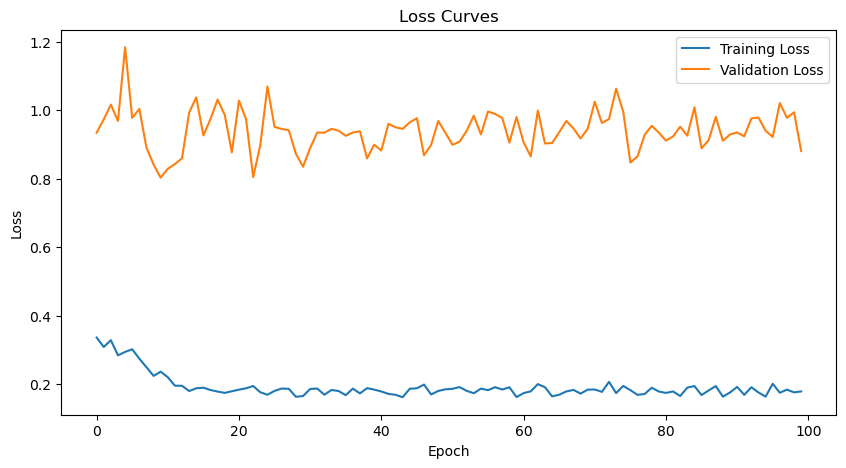

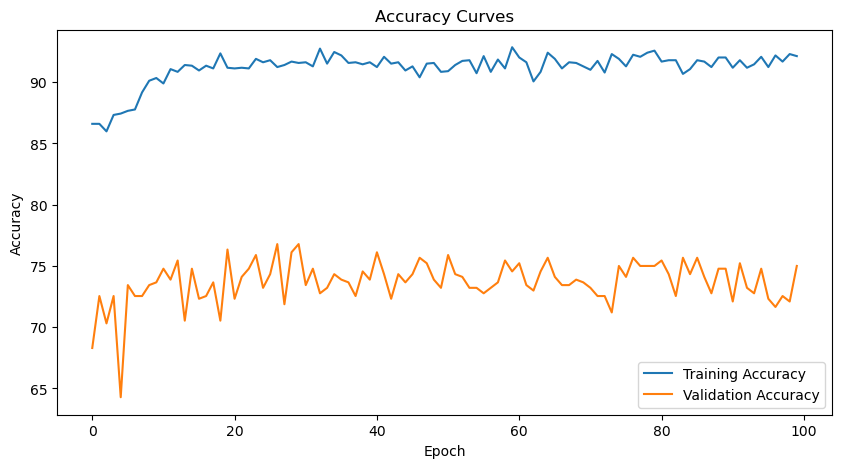

In [24]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

#  model performance on unseen data

In [25]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# Disable gradient computation for testing
with torch.no_grad():
    # Wrap test_loader with tqdm for a progress bar
    test_loop = tqdm(test_loader, desc="Testing")
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        loss = criterion(outputs, labels)

        # Update test loss
        test_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar description with current loss and accuracy
        test_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)

# Compute average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

# Print the results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Testing: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it, accuracy=51.7, loss=3.89] 

Test Loss: 2.7788, Test Accuracy: 51.69%


# Plotting the accuracy and the loss of the testing set

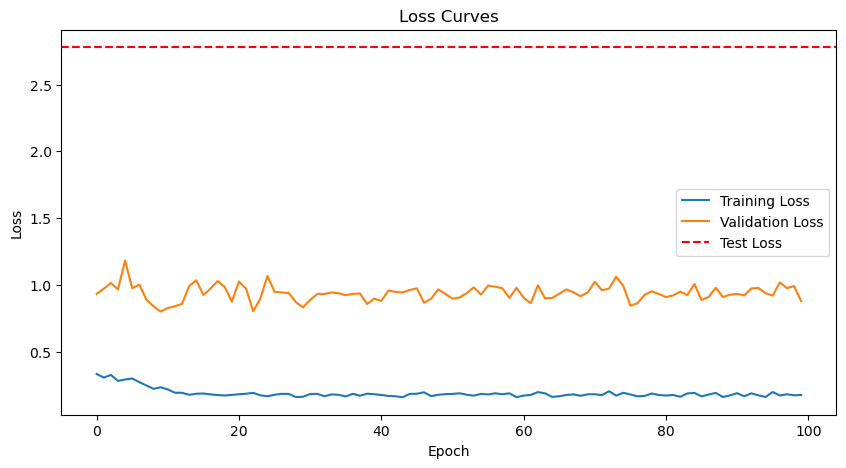

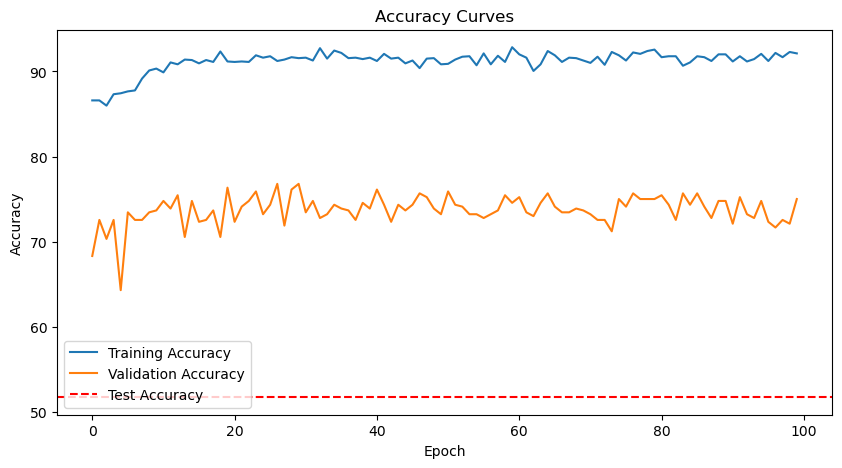

In [26]:
import matplotlib.pyplot as plt

# Plot training, validation, and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training, validation, and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Add test accuracy as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

# Code to Plot Confusion Matrix for Training Set

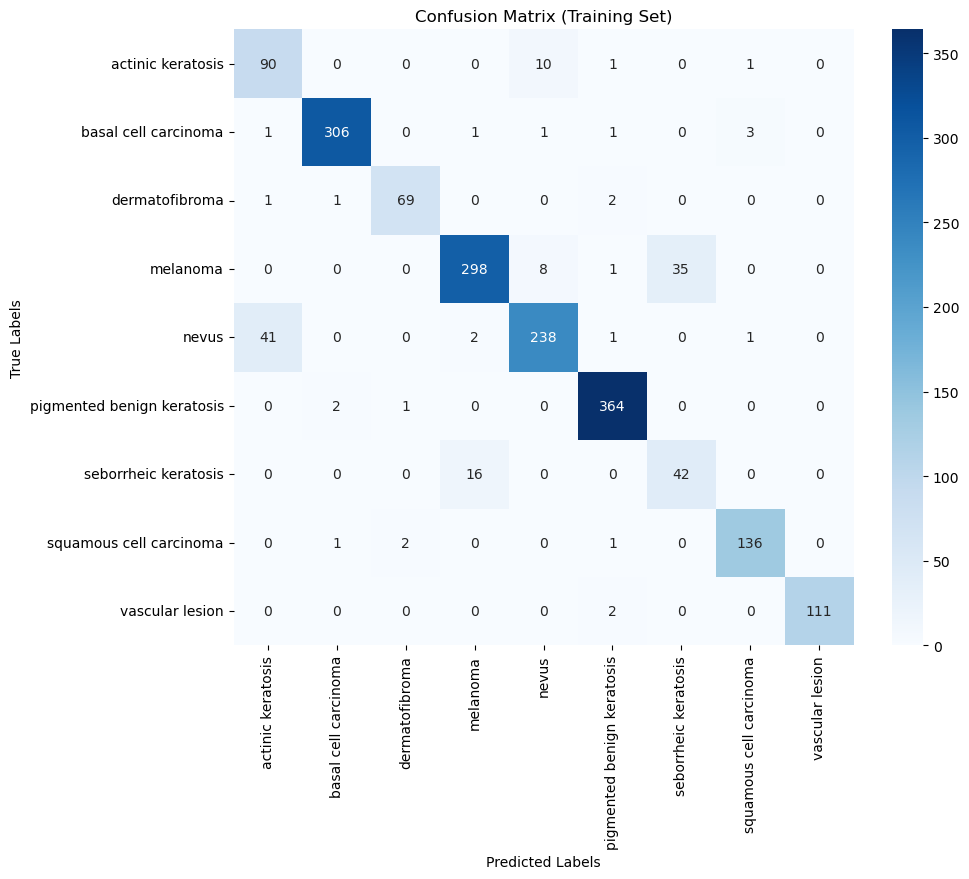

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Disable gradient computation for training set evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader instead of test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Training Set)')
plt.show()

# Code to Plot Confusion Matrix for Test Data

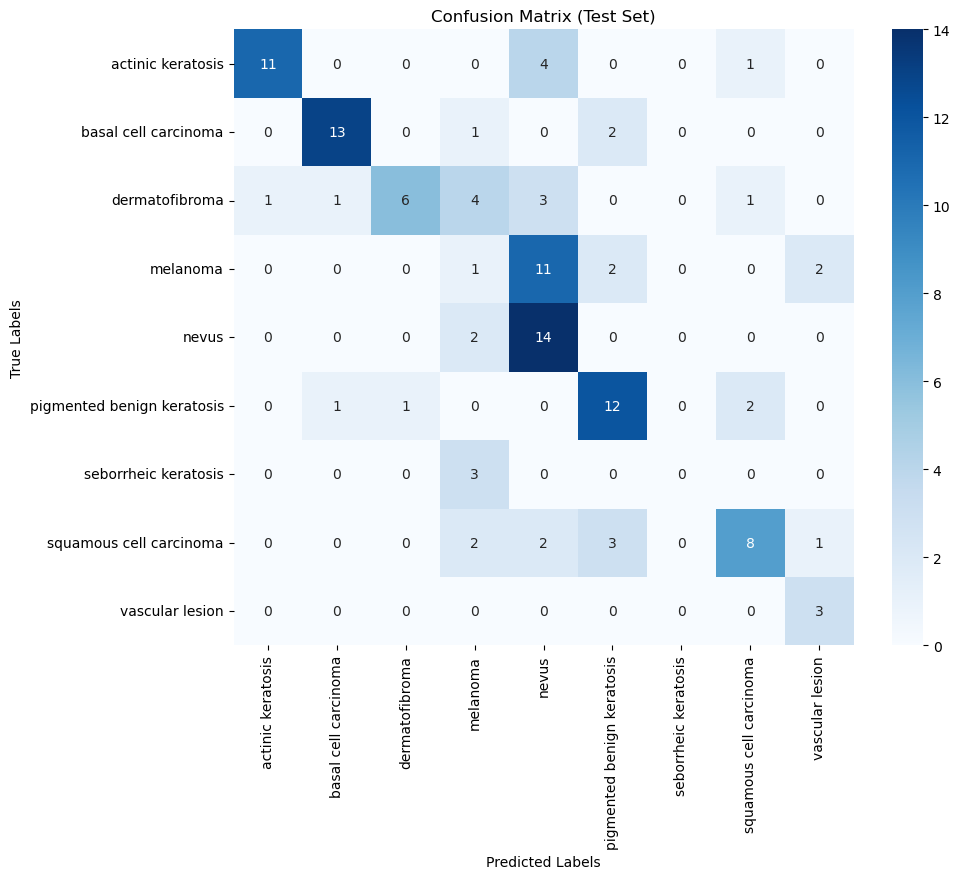

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute the confusion matrix for test data
cm_test = confusion_matrix(all_labels_test, all_preds_test)

# Plot the confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Code to Compute F1 Score, Precision, and Recall for Training Set

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for training data
all_preds_train = []
all_labels_train = []

# Disable gradient computation for training set evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds_train.extend(preds.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

# Compute F1 score, precision, and recall for training set
f1_train = f1_score(all_labels_train, all_preds_train, average='weighted')
precision_train = precision_score(all_labels_train, all_preds_train, average='weighted')
recall_train = recall_score(all_labels_train, all_preds_train, average='weighted')

# Print the results
print(f"Training F1 Score: {f1_train:.4f}")
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")

Training F1 Score: 0.9085
Training Precision: 0.9316
Training Recall: 0.9028


# Code to Compute F1 Score, Precision, and Recall for Test Set

In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute F1 score, precision, and recall for test set
f1_test = f1_score(all_labels_test, all_preds_test, average='weighted')
precision_test = precision_score(all_labels_test, all_preds_test, average='weighted')
recall_test = recall_score(all_labels_test, all_preds_test, average='weighted')

# Print the results
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")

Test F1 Score: 0.5897
Test Precision: 0.6385
Test Recall: 0.6017
